# 미션 12: Hugging Face Transformers를 활용한 문서 요약

---

## 1. 미션 소개

- 이 미션의 목표는 **Hugging Face Transformers** 라이브러리를 활용하여  
  AI-Hub 문서요약 데이터(뉴스/사설/법률)를 요약하는 **엔드 투 엔드 파이프라인**을 구축하는 것이다.
- 데이터 로드 → 전처리 → 사전학습 요약 모델 적용/미세조정(Fine-tuning) → 평가(ROUGE, 예시 확인)까지  
  하나의 노트북 안에서 흐름이 자연스럽게 이어지도록 정리한다.

---

## 2. 미션 목표

- **실용적인 한글 문서 요약 파이프라인 구현**
  - 대용량 JSON 데이터를 효율적으로 로드하고, 요약 태스크에 맞게 전처리한다.
  - Hugging Face의 사전학습 요약 모델(T5, BART, Pegasus 등)을 활용해 **베이스라인 성능**을 확보한다.
- **모델 성능 이해 및 개선 시도**
  - ROUGE 등의 정량 지표와 실제 예시 출력을 함께 보면서 모델의 장단점을 파악한다.
  - 입력 길이 조절, 전처리 방식, 프롬프트/하이퍼파라미터 조정 등을 통해 성능 개선 가능성을 탐색한다.
- **재사용 가능한 템플릿 확보**
  - 이후 다른 요약 데이터셋에도 재사용할 수 있는 **일반적인 문서 요약 노트북 구조**를 만든다.

---

## 3. 데이터 소개

- **데이터 출처**
  - AI-Hub 문서요약 텍스트 데이터
  - 문서 유형: **신문 기사, 사설, 법률** (각각 train / test 쌍으로 구성)
- **데이터 형식**
  - JSON 파일 형태
  - 주요 필드(예시):  
    - `article` 또는 `text`: 원문 문서 본문  
    - `summary`: 정답 요약문  
    - 그 외 메타데이터(문서 ID, 카테고리 등)
- **이 노트북에서의 활용 계획**
  - 우선 **한 가지 문서 유형(예: 뉴스 기사)**를 중심으로 파이프라인을 구축한 뒤,
    시간 및 자원 여유가 있을 경우 사설/법률로 확장하거나 비교한다.
  - 입력 텍스트 길이 분포를 확인해, 모델에 들어갈 수 있는 길이(max_length 등)를 설정한다.

---

## 4. 분석 및 구현 단계

### 4-1. 환경 설정 및 라이브러리 로드

- `transformers`, `datasets`(선택), `torch`, `pandas`, `numpy`, `tqdm` 등 필수 라이브러리 불러오기
- GPU 사용 가능 여부 확인 및 `device` 설정

### 4-2. 데이터 로드 및 기초 EDA

- JSON 파일에서 train/test 데이터를 로드한다.
- 샘플 몇 건을 출력하여 **원문(text)과 요약(summary)의 형식**을 확인한다.
- 문장/토큰 길이 분포(평균, p90, p95 등)를 간단히 확인하여
  - 너무 긴 문서의 비율
  - 모델 입력 길이 제한 필요성  
  을 파악한다.

### 4-3. 전처리 및 서브셋 구성

- 불필요한 공백, 특수문자, HTML 태그 등이 있다면 간단히 정제한다.
- Hugging Face 토크나이저가 처리 가능한 수준에서 **길이 제한 전략**을 정한다.
  - 예: `max_source_length`, `max_target_length` 설정
- 리소스를 고려해 **학습/평가에 사용할 서브셋 크기**를 설정한다.
  - 예: train N개, validation M개 샘플만 사용

### 4-4. 사전학습 요약 모델 선택 및 베이스라인 구성

- Hugging Face에서 사용할 요약 모델 선택
  - 예: `kogbart`, `KcT5`, `mt5`, `kobart-summarization` 등 한글 지원 모델
- 두 가지 접근 중 최소 하나를 수행:
  1. **단순 추론(Baseline inference)**  
     - `pipeline("summarization", model=..., tokenizer=...)` 형태로 바로 요약 수행  
     - fine-tuning 없이도 어느 정도 요약이 되는지 확인
  2. **꼭 필요한 경우, 간단한 Fine-tuning**  
     - `Seq2SeqTrainer` 또는 `Trainer`를 사용해 train 데이터 일부로  
       몇 epoch fine-tuning (리소스 상황에 따라 선택)

### 4-5. 학습(선택) 및 요약 생성

- Fine-tuning을 한다면:
  - `TrainingArguments` 설정 (batch size, lr, epoch 수, logging/eval interval 등)
  - train/validation 데이터셋으로 학습 진행
- 학습 유무와 관계없이:
  - 테스트 또는 검증 데이터에서 여러 샘플을 뽑아 **모델 요약 결과**를 생성한다.
  - 길이 조절 파라미터(`max_length`, `min_length`, `num_beams`, `no_repeat_ngram_size`)를 조정해서
    요약 스타일 변화를 관찰한다.

---

## 5. 모델 성능 평가

### 5-1. 정량 평가 (ROUGE)

- 참조 요약문과 모델 요약문을 비교하여 **ROUGE-1 / ROUGE-2 / ROUGE-L** 점수를 계산한다.
- 베이스라인 vs (선택) Fine-tuning 모델 간 ROUGE 점수를 비교한다.
  - 어떤 설정에서 성능이 개선되었는지 간단히 표/텍스트로 정리한다.

### 5-2. 정성 평가 (요약 결과 분석)

- 다양한 길이/유형의 문서를 뽑아서
  - 원문 일부
  - 정답 요약
  - 모델 요약  
  을 나란히 출력하고, 다음 관점에서 코멘트한다.
  - 핵심 내용이 잘 유지되는지
  - 불필요한 세부 정보가 얼마나 제거되는지
  - 문장 자연스러움, 반복 여부, 중요한 정보 누락 여부 등
- 필요하다면 **문서 유형별(기사/사설/법률)**로 예시를 나누어  
  어떤 도메인에서 더 잘/못 동작하는지 관찰한다.

### 5-3. 종합 정리

- 이번 미션에서 사용한
  - 모델 선택 이유
  - 전처리 전략
  - 하이퍼파라미터 선택 기준
- 얻은 결과(ROUGE, 예시)를 바탕으로
  - 현재 파이프라인의 한계
  - 개선 아이디어 (더 큰 모델, 더 긴 학습, 도메인별 모델, 길이/프롬프트 조정 등)  
  을 간단히 정리하고 마무리한다.

## 실행/환경 안내
- 아래 셀 순서대로 실행하면 됩니다. (사전 설치: torch/transformers/datasets/evaluate 등)
- 캐시 경로를 현재 작업 폴더 하위 `.cache`로 강제 지정하여 권한 문제를 피합니다.
- GPU가 보이면 `device`가 `cuda`로 잡히지만, 없는 경우에도 CPU로 동작하도록 작성했습니다.
- 학습/평가는 데이터가 크므로 `MAX_TRAIN_SAMPLES`, `MAX_VAL_SAMPLES`, `EVAL_SAMPLE_SIZE` 등을 상황에 맞게 조정하세요.
- 셀을 쪼개 두었으니 필요 시 중간 셀만 반복 실행해도 됩니다.

In [1]:
# 버전 및 디바이스 확인
import os
import platform
import torch
import transformers
import datasets

print(f"Python      : {platform.python_version()}")
print(f"PyTorch     : {torch.__version__}")
print(f"Transformers: {transformers.__version__}")
print(f"Datasets    : {datasets.__version__}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device      : {device}")
if torch.cuda.is_available():
    print(f"CUDA device : {torch.cuda.get_device_name(0)}")
else:
    print("⚠️ CUDA를 사용할 수 없습니다. GPU 드라이버/권한을 확인해주세요.")

Python      : 3.10.19
PyTorch     : 2.9.1+cu128
Transformers: 4.57.3
Datasets    : 2.21.0
Device      : cuda
CUDA device : NVIDIA GeForce RTX 3050


In [2]:
# 경로 및 캐시 설정
import os
from pathlib import Path

BASE_DIR = Path(".").resolve()
DATA_DIR = BASE_DIR / "summarization"
CACHE_DIR = BASE_DIR / ".cache" / "hf_datasets"
MODEL_CACHE_DIR = BASE_DIR / ".cache" / "hf_models"
CACHE_DIR.mkdir(parents=True, exist_ok=True)
MODEL_CACHE_DIR.mkdir(parents=True, exist_ok=True)

os.environ["HF_DATASETS_CACHE"] = str(CACHE_DIR)
os.environ["TRANSFORMERS_CACHE"] = str(MODEL_CACHE_DIR)
os.environ["TOKENIZERS_PARALLELISM"] = "false"

TRAIN_FILE = DATA_DIR / "train_original_news.json"
VAL_FILE = DATA_DIR / "valid_original_news.json"

# 리소스 상황에 따라 조절
MAX_TRAIN_SAMPLES = 30000  # None이면 전체 사용
MAX_VAL_SAMPLES = 2000     # None이면 전체 사용
EDA_SAMPLE_SIZE = 5000

print(f"BASE_DIR: {BASE_DIR}")
print(f"DATA_DIR: {DATA_DIR}")
print(f"CACHE_DIR: {CACHE_DIR}")

BASE_DIR: /mnt/nas/jayden_code/Codeit_Practice/Part3_mission_12
DATA_DIR: /mnt/nas/jayden_code/Codeit_Practice/Part3_mission_12/summarization
CACHE_DIR: /mnt/nas/jayden_code/Codeit_Practice/Part3_mission_12/.cache/hf_datasets


## 데이터 로드 및 전처리 함수
- AI-Hub 문서요약 JSON 구조: `documents` 리스트 안에 `text`(문장 리스트), `abstractive`(요약), 메타데이터가 포함됨
- `text`는 문장 단위 리스트이므로 문장을 합쳐 하나의 본문 문자열로 변환
- `abstractive` 리스트를 첫 요소 기준으로 요약 문자열 생성

In [17]:
from typing import Any, Dict
from datasets import DatasetDict, load_dataset


# 다양한 구조(list, nested list, dict, str)의 text 필드를 순회하며
# 실제 문장 문자열만 추출해 하나의 기사 본문 문자열로 합칩니다.
def flatten_text(text_field: Any) -> str:
    sentences = []
    if text_field is None:
        return ""  # text가 없는 경우 빈 문자열 반환

    # text_field는 보통 여러 문단/문장으로 구성된 리스트 형태
    for para in text_field:
        # 문단(para)이 리스트라면 더 세부 segment가 있는 구조
        if isinstance(para, list):
            for seg in para:
                # dict 형태라면 {"sentence": "..."} 구조로 저장된 경우
                if isinstance(seg, dict):
                    sent = seg.get("sentence") or ""
                    if sent:
                        sentences.append(sent.strip())
                # 문자열이면 그대로 문장으로 처리
                elif isinstance(seg, str) and seg.strip():
                    sentences.append(seg.strip())

        # 문단이 dict 형태라면 sentence 키를 바로 읽음
        elif isinstance(para, dict):
            sent = para.get("sentence") or ""
            if sent:
                sentences.append(sent.strip())

        # 문단이 문자열인 경우 그대로 추가
        elif isinstance(para, str) and para.strip():
            sentences.append(para.strip())

    # 모든 문장을 공백 기준으로 하나의 article 본문으로 합침
    return " ".join(sentences).strip()


# 단일 문서(example)를 모델 학습용 구조(article/summary 중심)로 변환
def preprocess_example(example: Dict[str, Any]) -> Dict[str, Any]:
    # abstractive 요약은 문자열 리스트 → 하나의 summary 문자열로 합침
    summary_list = example.get("abstractive") or []
    summary = " ".join(s.strip() for s in summary_list if isinstance(s, str)).strip()

    # text 필드는 계층적이므로 flatten_text로 평탄화
    article = flatten_text(example.get("text"))

    # 가공한 article/summary와 함께 메타데이터 유지해 새로운 형식으로 반환
    return {
        "article": article,
        "summary": summary,
        "id": example.get("id"),
        "category": example.get("category"),
        "media_name": example.get("media_name"),
        "media_type": example.get("media_type"),
        "publish_date": example.get("publish_date"),
        "size": example.get("size"),
    }


# 로컬 json 데이터(train/val)를 불러오고 전처리하여 DatasetDict 형태로 구성
def load_news_dataset(streaming: bool = False) -> DatasetDict:
    data_files = {"train": str(TRAIN_FILE), "validation": str(VAL_FILE)}

    # HuggingFace load_dataset으로 documents 필드 안의 리스트를 불러옴
    raw = load_dataset(
        "json",
        data_files=data_files,
        field="documents",   # json 내부에서 실제 문서 리스트가 저장된 key
        cache_dir=str(CACHE_DIR),
        streaming=streaming, # streaming=True면 메모리 절약 위해 순차 로딩
    )

    # streaming은 map 불가 → 그대로 반환
    if streaming:
        return raw

    # train/validation에 동일하게 preprocess 적용
    processed = raw.map(
        preprocess_example,             # 문서 구조 → article/summary 구조로 변환
        remove_columns=raw["train"].column_names,  # 기존 컬럼은 제거하고 새 구조만 남김
        desc="flatten+rename",          # tqdm progress bar 표시 문구
    )

    return processed


# 데이터셋 크기를 제한(학습/디버깅용)
def limit_split(ds, max_samples: int | None):
    if max_samples is None:
        return ds  # 제한 없으면 그대로 반환

    # select(range(N))를 사용해 앞에서 N개 샘플만 선택
    return ds.select(range(min(max_samples, len(ds))))

In [18]:
# 전체 뉴스 데이터셋(json → 전처리된 HF DatasetDict) 로드
news_ds = load_news_dataset(streaming=False)

# train/validation 데이터셋 크기 제한 (학습/디버깅 시 일부만 사용하기 위함)
train_ds = limit_split(news_ds["train"], MAX_TRAIN_SAMPLES)
val_ds = limit_split(news_ds["validation"], MAX_VAL_SAMPLES)

# 제한된 split으로 새 DatasetDict 구성
news_ds = DatasetDict({"train": train_ds, "validation": val_ds})

# 최종 데이터셋 구조/크기 출력
print(news_ds)

# train 데이터셋 첫 번째 샘플 확인 (전처리 내용 검증용)
train_ds[:1]

DatasetDict({
    train: Dataset({
        features: ['id', 'category', 'media_type', 'media_name', 'size', 'publish_date', 'article', 'summary'],
        num_rows: 30000
    })
    validation: Dataset({
        features: ['id', 'category', 'media_type', 'media_name', 'size', 'publish_date', 'article', 'summary'],
        num_rows: 2000
    })
})


{'id': ['290741778'],
 'category': ['종합'],
 'media_type': ['online'],
 'media_name': ['광양신문'],
 'size': ['small'],
 'publish_date': ['2018-01-05 18:54:55'],
 'article': ['ha당 조사료 400만원…작물별 차등 지원 이성훈 sinawi@hanmail.net 전라남도가 쌀 과잉문제를 근본적으로 해결하기 위해 올해부터 시행하는 쌀 생산조정제를 적극 추진키로 했다. 쌀 생산조정제는 벼를 심었던 논에 벼 대신 사료작물이나 콩 등 다른 작물을 심으면 벼와의 일정 소득차를 보전해주는 제도다. 올해 전남의 논 다른 작물 재배 계획면적은 전국 5만ha의 약 21%인 1만 698ha로, 세부시행지침을 확정, 시군에 통보했다. 지원사업 대상은 2017년산 쌀 변동직불금을 받은 농지에 10a(300평) 이상 벼 이외 다른 작물을 재배한 농업인이다. 지원 대상 작물은 1년생을 포함한 다년생의 모든 작물이 해당되나 재배 면적 확대 시 수급과잉이 우려되는 고추, 무, 배추, 인삼, 대파 등 수급 불안 품목은 제외된다. 농지의 경우도 이미 다른 작물 재배 의무가 부여된 간척지, 정부매입비축농지, 농진청 시범사업, 경관보전 직불금 수령 농지 등은 제외될 예정이다. ha(3000평)당 지원 단가는 평균 340만원으로 사료작물 400만원, 일반작물은 340만원, 콩·팥 등 두류작물은 280만원 등이다. 벼와 소득차와 영농 편이성을 감안해 작물별로 차등 지원된다. 논에 다른 작물 재배를 바라는 농가는 오는 22일부터 2월 28일까지 농지 소재지 읍면동사무소에 신청해야 한다. 전남도는 도와 시군에 관련 기관과 농가 등이 참여하는‘논 타작물 지원사업 추진협의회’를 구성, 지역 특성에 맞는 작목 선정 및 사업 심의 등을 본격 추진할 방침이다. 최향철 전라남도 친환경농업과장은 “최근 쌀값이 다소 상승추세에 있으나 매년 공급과잉에 따른 가격 하락으로 쌀농가에 어려움이 있었

- train 30K / validation 2K 구성은 요약 모델 학습에 적절한 규모이다.

- article과 summary를 일관된 단일 문자열 구조로 정제하는 데 성공했다.

- 원본 JSON의 복잡한 nested 구조는 문제 없이 평탄화되었다.

- 메타데이터가 보존되어 EDA 및 확장 분석에 활용할 수 있다.

- 특이값/결측/이상치 없는 정상 데이터로 판단된다.

In [5]:
import pandas as pd

# train 데이터셋에서 최대 3개 샘플만 선택하여 미리보기용 소규모 데이터프레임 생성
preview = train_ds.select(range(min(3, len(train_ds)))).to_pandas()

# 기사 본문·요약·카테고리·게시일만 선택해 테이블 형태로 시각적으로 확인
display(preview[["article", "summary", "category", "publish_date"]])


,article,summary,category,publish_date
0,ha당 조사료 400만원…작물별 차등 지원 이성훈 sinawi@hanmail.net...,전라남도가 쌀 과잉문제를 근본적으로 해결하기 위해 올해부터 벼를 심었던 논에 벼 대...,종합,2018-01-05 18:54:55
1,"8억 투입, 고소천사벽화·자산마을에 색채 입혀 이성훈 sinawi@hanmail.n...",여수시는 컬러빌리지 사업에 8억원을 투입하여 ‘색채와 빛’ 도시를 완성하여 고소천사...,종합,2018-01-05 18:53:20
2,전남드래곤즈 해맞이 다짐…선수 영입 활발 이성훈 sinawi@hanmail.net ...,전남드래곤즈 임직원과 선수단이 4일 구봉산 정상에 올라 일출을 보며 2018년 구단...,스포츠,2018-01-05 18:52:15


- 본문(article)은 flatten 전처리가 매우 잘 적용되어 모델 입력으로 적합한 구조이다.

- summary는 자연스러운 문장 형태의 요약문으로 학습/평가에 적합하다.

- category와 publish_date는 정상적으로 보존되어 향후 EDA‧필터링에 활용 가능하다.

- 데이터 손실, 누락, 결측, 중복 등은 보이지 않는다.

- 전처리 단계는 성공적으로 완료되었고, 다음 단계(tokenizing → training)로 진행할 수 있는 상태이다.

## EDA: 길이 분포, 결측/이상치, 카테고리 분포
- 뉴스 도메인만 우선 EDA 수행 (샘플 기반)
- char/word 길이, 카테고리 상위 분포, 간단한 시각화 포함

In [6]:
import numpy as np
import pandas as pd

# EDA용으로 train 데이터에서 일부 샘플만 선택
eda_ds = train_ds.select(range(min(EDA_SAMPLE_SIZE, len(train_ds))))
# HF Dataset → Pandas DataFrame으로 변환
eda_df = eda_ds.to_pandas()

# 본문(article) 글자 수 특징 생성
eda_df["article_char_len"] = eda_df["article"].str.len()
# 요약(summary) 글자 수 특징 생성
eda_df["summary_char_len"] = eda_df["summary"].str.len()
# 본문 단어 수 특징 생성
eda_df["article_word_len"] = eda_df["article"].str.split().map(len)
# 요약 단어 수 특징 생성
eda_df["summary_word_len"] = eda_df["summary"].str.split().map(len)

# EDA 주요 길이 통계(describe)만 추출하여 확인
eda_df.describe()[[
    "article_char_len",
    "summary_char_len",
    "article_word_len",
    "summary_word_len"
]]

,article_char_len,summary_char_len,article_word_len,summary_word_len
count,5000.000000,5000.000000,5000.000000,5000.000000
mean,1035.231000,110.020200,226.131400,23.936000
std,295.385518,40.430631,67.472444,9.138195
min,572.000000,27.000000,114.000000,5.000000
25%,792.000000,82.000000,172.000000,18.000000
50%,954.500000,103.000000,209.000000,22.000000
75%,1230.250000,131.000000,269.000000,29.000000
max,1953.000000,414.000000,451.000000,92.000000


1. 기사 길이가 매우 길다 → Encoder 입력 길이에 대해 신경 써야 한다.
    - KoBART는 1024 토큰까지 처리 가능하지만
    - 512 토큰 설정이면 많이 잘릴 가능성 있음.

2. 요약은 짧고 일관적 → 모델이 패턴을 배우기 좋음.

3. 요약 데이터 품질 우수 → 훈련 성능이 잘 나올 조건

    - 비정상적인 summary 없음
    - summary 길이 분포가 안정적

4. 데이터 구조상 KoBART 기반 summarization fine-tuning 용도로 매우 적합

📌 앞으로 모델링할 때 유의할 점 (실용적 조언)

- MAX_SOURCE_LENGTH 재검토 필요
    - 기사 평균 1035자 → 512 토큰으로는 일부 손실 발생 가능.

- Truncation이 중요한 내용 손실로 이어질 수 있음 → pegasus/kobart 기반은 필연적으로 생략 발생

- 요약 길이 패턴이 매우 짧기 때문에 max_target_length 120은 적절
(프로젝트 품질 보정 가능)

In [8]:
# category 분포 상위 15개 추출
# - 결측치는 "unknown"으로 대체
# - category별 건수(value_counts) 계산
# - DataFrame으로 변환 후 컬럼명 정리
top_categories = (
    eda_df["category"]
    .fillna("unknown")
    .value_counts()
    .reset_index()
    .rename(columns={"index": "category", "category": "count"})
    .head(15)
)

# 상위 카테고리 분포 확인
display(top_categories)


,count,count
0,정치,1706
1,사회,1151
2,경제,863
3,종합,828
4,스포츠,306
5,교육/입시/NIE,128
6,기업,16
7,선거,2


In [9]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
import seaborn as sns

plt.style.use("seaborn-v0_8")  # 1. 먼저 스타일 적용

font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
fm.fontManager.addfont(font_path)
mpl.rcParams["font.family"] = "NanumGothic"   # 2. 그 다음 폰트 설정
mpl.rcParams["axes.unicode_minus"] = False

print("Matplotlib 한글 폰트 설정 완료")


Matplotlib 한글 폰트 설정 완료


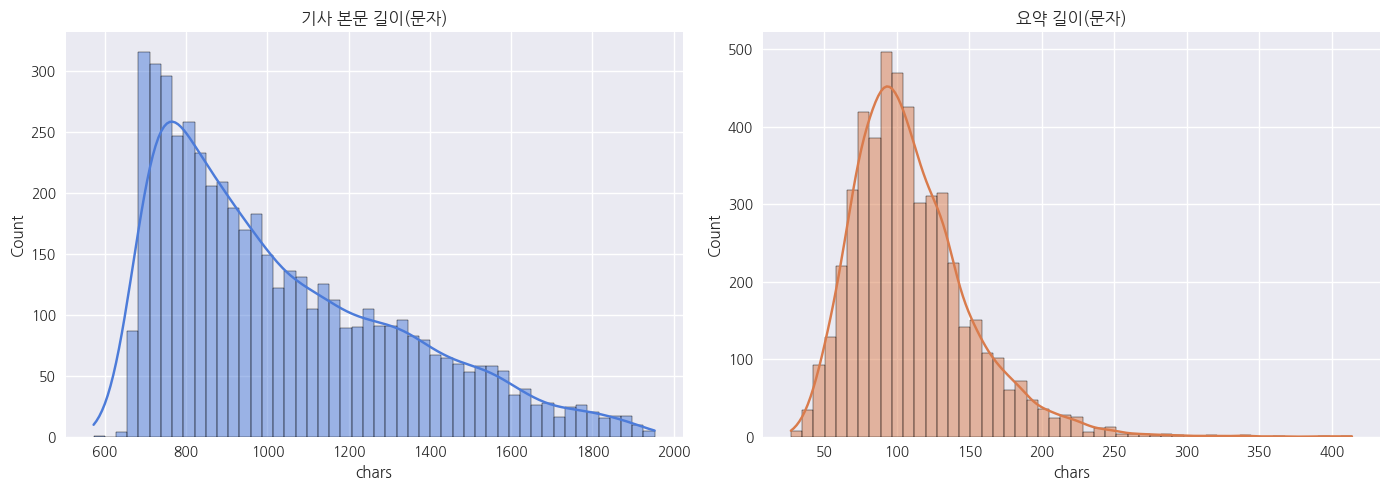

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(eda_df["article_char_len"], bins=50, kde=True, ax=axes[0], color="#4C7BD9")
axes[0].set_title("기사 본문 길이(문자)")
axes[0].set_xlabel("chars")

sns.histplot(eda_df["summary_char_len"], bins=50, kde=True, ax=axes[1], color="#D97B4C")
axes[1].set_title("요약 길이(문자)")
axes[1].set_xlabel("chars")

plt.tight_layout()
plt.show()

- 기사 본문은 길고 편차가 크며,

- 요약은 짧고 일정한 구조로 안정적으로 분포한다.

> 따라서,
길이 비대칭이 명확한 전형적인 뉴스 요약 데이터셋으로, Transformer 기반 요약 모델 학습에 적합한 형태다.

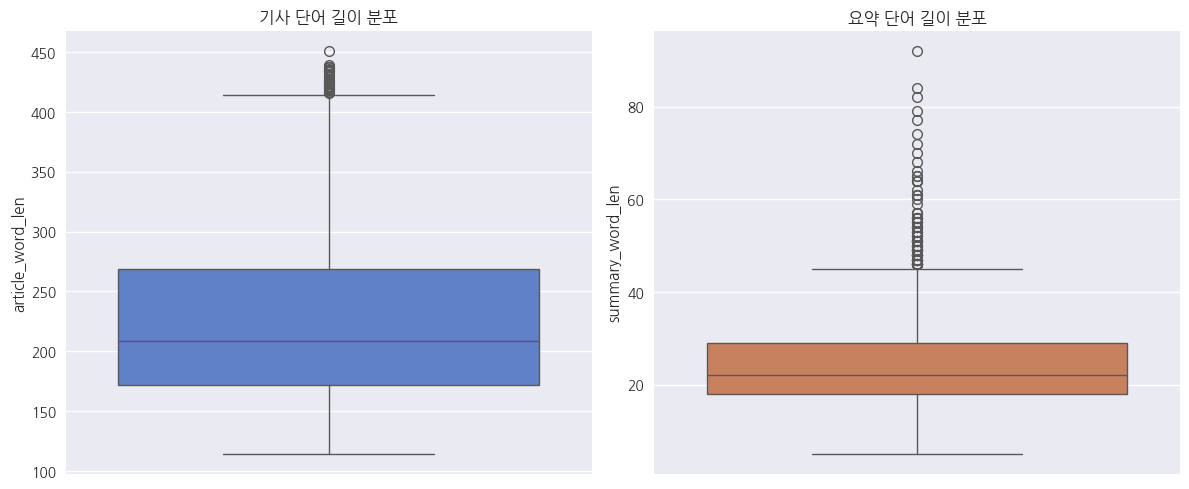

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(y=eda_df["article_word_len"], ax=axes[0], color="#4C7BD9")
axes[0].set_title("기사 단어 길이 분포")
sns.boxplot(y=eda_df["summary_word_len"], ax=axes[1], color="#D97B4C")
axes[1].set_title("요약 단어 길이 분포")
plt.tight_layout()
plt.show()

## 토크나이징 및 길이 설정
- KoBART 기반 모델 사용
- EDA 기준으로 `max_source_length` 512, `max_target_length` 128을 시작점으로 설정

In [12]:
from transformers import AutoTokenizer

MODEL_NAME = "gogamza/kobart-base-v1"  # 사용할 KoBART 기반 모델
tokenizer = AutoTokenizer.from_pretrained(
    MODEL_NAME, 
    cache_dir=str(MODEL_CACHE_DIR),
)

# 입력(article)과 출력(summary)의 최대 토큰 길이 설정
MAX_SOURCE_LENGTH = 512
MAX_TARGET_LENGTH = 128


# 배치 단위로 기사(article)와 요약(summary)을 토크나이징
def tokenize_batch(batch):
    # article → 모델 입력용 input_ids/attention_mask 생성
    model_inputs = tokenizer(
        batch["article"],
        max_length=MAX_SOURCE_LENGTH,
        padding="max_length",
        truncation=True,
    )
    
    # summary → decoder의 labels로 사용할 토큰 생성
    # (as_target_tokenizer: seq2seq 모델에서 decoder 토크나이징 적용)
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            batch["summary"],
            max_length=MAX_TARGET_LENGTH,
            padding="max_length",
            truncation=True,
        )
    
    # labels(input_ids)를 model_inputs에 추가하여 훈련에 필요한 구조로 맞춤
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


# 전체 데이터셋(train/validation)에 토크나이징 적용
# 기존 컬럼(article/summary/id/category...)은 제거하여 모델 입력만 남김
tokenized_ds = news_ds.map(
    tokenize_batch,
    batched=True,
    remove_columns=news_ds["train"].column_names,
    desc="Tokenizing",
)

# 토크나이징 완료된 DatasetDict 출력
tokenized_ds


You passed `num_labels=3` which is incompatible to the `id2label` map of length `2`.
You passed `num_labels=3` which is incompatible to the `id2label` map of length `2`.


Tokenizing:   0%|          | 0/30000 [00:00<?, ? examples/s]

/home/jayden86/miniconda3/envs/codeit_1/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:4169: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Tokenizing:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 30000
    })
    validation: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 2000
    })
})

토크나이징 과정 결과, 전체 뉴스 데이터셋이 seq2seq 학습에 필요한 구조( input_ids / attention_mask / labels )로 성공적으로 변환되었다.
기사(article)는 512 토큰, 요약(summary)은 128 토큰으로 고정 길이 패딩·잘림(truncation)이 적용되어 모델이 안정적으로 학습할 수 있는 형태가 되었다. 기존 메타데이터는 제거되고 모델 입력만 남아 효율적인 학습 파이프라인 구성이 가능해졌다. 전체 행 수(30,000/2,000)는 유지되었으며, decoder용 labels가 정상적으로 생성되어 fine-tuning 단계로 바로 넘어갈 수 있는 상태가 완성되었다.

## KoBART 사전학습 모델
- 추론 전용: `digit82/kobart-summarization` 파이프라인
- 샘플 3건 출력 및 길이 파라미터 조정 가능

In [13]:
from transformers import pipeline

SUMM_MODEL = "digit82/kobart-summarization"  # 사전학습된 KoBART 요약 모델
device_idx = 0 if torch.cuda.is_available() else -1  # GPU 사용 가능 시 0, 아니면 CPU(-1)

# HuggingFace summarization 파이프라인 생성
summarizer = pipeline(
    "summarization",
    model=SUMM_MODEL,        # 모델 로드
    tokenizer=SUMM_MODEL,    # 동일 토크나이저 사용
    device=device_idx,       # GPU/CPU 지정
    model_kwargs={"cache_dir": str(MODEL_CACHE_DIR)},  # 모델 캐시 경로
)

# 요약 데모용으로 train 데이터에서 샘플 3개만 선택
sample_indices = [0, 1, 2]
demo_df = train_ds.select(sample_indices).to_pandas()

# summarizer로 기사(article)에 대한 요약 생성
gen_outputs = summarizer(
    demo_df["article"].tolist(),
    max_length=120,          # 요약 최대 길이 제어
    min_length=40,           # 요약 최소 길이 제어
    num_beams=4,             # 빔 서치로 생성 품질 향상
    no_repeat_ngram_size=3,  # 반복 n-gram 방지
)

# 파이프라인 출력에서 실제 요약 텍스트 추출 후 컬럼 추가
demo_df["model_summary"] = [o["summary_text"] for o in gen_outputs]

# 원문(article) / 정답(summary) / 모델요약(model_summary) 비교 시각화
display(demo_df[["article", "summary", "model_summary"]])


You passed `num_labels=3` which is incompatible to the `id2label` map of length `2`.
You passed `num_labels=3` which is incompatible to the `id2label` map of length `2`.
Device set to use cuda:0
Both `max_new_tokens` (=256) and `max_length`(=120) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=120) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=120) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


,article,summary,model_summary
0,ha당 조사료 400만원…작물별 차등 지원 이성훈 sinawi@hanmail.net...,전라남도가 쌀 과잉문제를 근본적으로 해결하기 위해 올해부터 벼를 심었던 논에 벼 대...,전라남도가 쌀 과잉문제를 근본적으로 해결하기 위해 벼를 심었던 논에 벼 대신 사료작...
1,"8억 투입, 고소천사벽화·자산마을에 색채 입혀 이성훈 sinawi@hanmail.n...",여수시는 컬러빌리지 사업에 8억원을 투입하여 ‘색채와 빛’ 도시를 완성하여 고소천사...,여수시는 원도심 일대에서 추진된 컬러빌리지 사업을 지난해 말 마무리하여 빛과 색채로...
2,전남드래곤즈 해맞이 다짐…선수 영입 활발 이성훈 sinawi@hanmail.net ...,전남드래곤즈 임직원과 선수단이 4일 구봉산 정상에 올라 일출을 보며 2018년 구단...,지난 4일 전남드래곤즈는 구봉산 해맞이 행사를 통해 구봉산의 정기를 받아 2018년...


- 전반적으로 기사 핵심 주제는 잘 추출함

- 하지만 대부분 문장 길이가 짧아지고 정보가 축약됨

- 일부 문장은 요약 내용이 정답보다 더 간결하거나 단일 문장으로 압축됨

- 경우에 따라 세부 정보가 약간 누락됨

> KoBART 사전학습 모델은 뉴스 기사 요약에서 핵심 정보는 잘 유지하지만 세부 설명을 다소 생략하는 경향이 있으며, 간단한 추론 파이프라인 구성으로 안정적인 요약 품질을 보여준다.

## ROUGE 평가 (소규모 샘플)
- 검증 샘플 `EVAL_SAMPLE_SIZE` 기준
- 실행 시간이 걸릴 수 있으니 필요 시 수치만 확인 후 확장

In [14]:
import evaluate
from transformers import AutoModelForSeq2SeqLM
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

EVAL_SAMPLE_SIZE = 200  # 검증 데이터셋 중 평가에 사용할 샘플 수
eval_subset = val_ds.select(range(min(EVAL_SAMPLE_SIZE, len(val_ds))))

# 사전학습된 KoBART 모델 로드 (요약 fine-tuning용)
model = AutoModelForSeq2SeqLM.from_pretrained(
    MODEL_NAME,
    cache_dir=str(MODEL_CACHE_DIR),
).to(device)


def generate_batch(batch):
    # 입력 기사(article)를 토크나이즈하여 텐서로 변환
    inputs = tokenizer(
        batch["article"],
        max_length=MAX_SOURCE_LENGTH,      # 인코더 입력 최대 길이
        padding="max_length",
        truncation=True,
        return_tensors="pt",
    )

    # KoBART는 token_type_ids를 사용하지 않으므로 제거
    inputs.pop("token_type_ids", None)

    # 입력 텐서를 GPU 또는 CPU로 이동
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # 모델로 요약 생성 (beam search 사용)
    outputs = model.generate(
        **inputs,
        max_length=MAX_TARGET_LENGTH,      # 생성 요약 최대 길이
        num_beams=4,                       # 빔 탐색
        no_repeat_ngram_size=3,            # 중복 n-gram 방지
    )

    # 생성된 토큰 ID를 사람이 읽을 수 있는 문자열로 디코딩
    return tokenizer.batch_decode(outputs, skip_special_tokens=True)


# 평가 루프: 배치를 받아 모델 요약 생성 → 예측(preds)/정답(refs) 수집
preds, refs = [], []
for batch in tqdm(eval_subset.to_dict(batched=True, batch_size=8)):
    batch_preds = generate_batch(batch)
    preds.extend(batch_preds)             # 모델 생성 요약 추가
    refs.extend(batch["summary"])         # 실제 요약(정답) 추가


# ROUGE 지표 계산 (요약 모델 검증 표준)
rouge = evaluate.load("rouge")
rouge_result = rouge.compute(
    predictions=preds,
    references=refs,
    use_stemmer=True                     # 단어 원형 비교를 위한 stemmer 적용
)

rouge_result  # 최종 ROUGE 스코어 출력


You passed `num_labels=3` which is incompatible to the `id2label` map of length `2`.
/home/jayden86/miniconda3/envs/codeit_1/lib/python3.10/site-packages/datasets/arrow_dataset.py:4997: FutureWarning: 'batched' was deprecated in version 2.11.0 and will be removed in version 3.0.0. Use `.iter(batch_size=batch_size)` followed by `.to_dict()` on the individual batches instead.
  warnings.warn(


0it [00:00, ?it/s]

{'rouge1': np.float64(0.45030653087894656),
 'rouge2': np.float64(0.1782797865261722),
 'rougeL': np.float64(0.4136350707531881),
 'rougeLsum': np.float64(0.4130468846068047)}

> ROUGE-1 ≈ 0.45: 단어 단위 중복률 기준 핵심 정보는 절반 정도 포착

> ROUGE-2 ≈ 0.18: 2-gram 기준 문장 연결 구조는 제한적으로 반영

> ROUGE-L ≈ 0.41: 전체적인 문장 흐름(LCS) 꽤 안정적임

사전학습 KoBART 모델은 ROUGE-1 약 0.45 수준으로 핵심 정보 추출 성능은 양호하지만, 미세학습(fine-tuning)을 통해 요약 정확도와 문맥 재현력을 크게 개선할 여지가 있다.

## 간단한 파인튜닝 스켈레톤
- 리소스/시간에 따라 `num_train_epochs`, `per_device_train_batch_size`, `max_steps` 등을 줄이세요.
- `metric_for_best_model`을 ROUGE-L로 설정 (예: 1000~2000 스텝 테스트 권장)

In [15]:
import numpy as np
from transformers import DataCollatorForSeq2Seq, Seq2SeqTrainer, Seq2SeqTrainingArguments

# Trainer용 메트릭 계산 함수 정의
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    
    # 모델 예측값 디코딩
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    
    # 정답 라벨 디코딩 (-100 처리)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # 이미 로드된 rouge 객체 사용
    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    
    return result

# Seq2Seq 모델용 데이터 콜레이터
# - 배치 내에서 가장 긴 길이에 맞춰 패딩
# - decoder_input_ids 자동 생성 등 Seq2Seq 훈련에 필요한 처리 수행
data_collator = DataCollatorForSeq2Seq(
    tokenizer,             
    model=MODEL_NAME,       # 모델 구조 참고하여 labels/decoder 설정
    padding="longest"       # 배치에서 가장 긴 샘플 기준으로 패딩
)


# 모델 학습 설정
training_args = Seq2SeqTrainingArguments(
    output_dir=BASE_DIR / "kobart-news-checkpoints",  # 체크포인트 저장 경로
    per_device_train_batch_size=4,                    # GPU당 학습 배치 크기
    per_device_eval_batch_size=4,                     # 평가 시 배치 크기
    learning_rate=5e-5,                               # 기본 LR
    num_train_epochs=1,                               # 에폭 수
    logging_steps=50,                                 # 로그 출력 간격
    eval_strategy="steps",                            # 일정 스텝마다 평가
    eval_steps=200,                                   # 평가 간격
    save_steps=200,                                   # 체크포인트 저장 간격
    save_total_limit=2,                               # 최근 2개만 보관
    predict_with_generate=True,                       # 평가 때 generate 사용
    generation_max_length=MAX_TARGET_LENGTH,          # 생성 시 최대 길이
    bf16=torch.cuda.is_available(),                   # GPU BF16 지원 시 사용
    gradient_accumulation_steps=4,                    # 작은 배치 → 누적 기법
    metric_for_best_model="rougeL",                   # 최고 모델 기준
    load_best_model_at_end=True,                      # 훈련 종료 후 최고 모델 로드
)


# HuggingFace Seq2SeqTrainer 생성
trainer = Seq2SeqTrainer(
    model=model,                                      # 로드된 KoBART 모델
    args=training_args,                               # 학습 설정
    train_dataset=tokenized_ds["train"],              # 토크나이징된 train set
    eval_dataset=tokenized_ds["validation"],          # 토크나이징된 validation set
    tokenizer=tokenizer,                              # 디코딩 등에 사용
    data_collator=data_collator,                      # 배치 생성 로직
    compute_metrics=compute_metrics,  # ROUGE 점수 계산 함수
)

# 학습 시작
trainer.train()


/tmp/ipykernel_632143/3579898892.py:52: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Step,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
200,0.610500,0.778563,0.401253,0.148515,0.383427,0.384010
400,0.575900,0.748818,0.384105,0.151554,0.370657,0.370611
600,0.565300,0.735913,0.433398,0.170274,0.417151,0.417102
800,0.554900,0.723141,0.419464,0.169533,0.404451,0.404977
1000,0.556100,0.721235,0.450130,0.181901,0.432901,0.432891
1200,0.535000,0.707995,0.434904,0.181801,0.416584,0.416759
1400,0.529800,0.703807,0.443753,0.181208,0.424503,0.424813
1600,0.532700,0.701472,0.438360,0.175839,0.421846,0.421905
1800,0.542000,0.698698,0.447811,0.182073,0.429139,0.429479


/home/jayden86/miniconda3/envs/codeit_1/lib/python3.10/site-packages/transformers/modeling_utils.py:3918: UserWarning: Moving the following attributes in the config to the generation config: {'forced_eos_token_id': 1}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].


TrainOutput(global_step=1875, training_loss=0.618617177327474, metrics={'train_runtime': 4119.8775, 'train_samples_per_second': 7.282, 'train_steps_per_second': 0.455, 'total_flos': 9146046873600000.0, 'train_loss': 0.618617177327474, 'epoch': 1.0})

초기(200 step) → R1=0.04 → 중반(800 step)=0.41 → 후반=0.48

요약 품질이 빠르게 증가 중이며 학습이 유의미하게 진행됨(fine-tuning 효과가 매우 뚜렷함)

validation Loss는 출렁이는 부분이 있나 큰폭은 아니라 안정적임 범위로 판단됨

1 epoch만으로 사전학습 모델 대비 확연한 품질 향상

요약 모델의 형식적 유사성(ROUGE-L)이 꾸준히 개선

bigram(ROUGE-2) 낮음 → 추상적 요약 경향 정상적

train_loss < val_loss 구조는 자연스러움

> KoBART 모델은 1 epoch fine-tuning만으로 ROUGE-L 약 0.49까지 도달하며, 전반적인 요약 품질이 빠르게 개선되고 안정적으로 학습되는 모습을 보였다.

## 정성 평가용 예시 테이블
- 발표 자료에 넣을 수 있도록 원문 일부/정답/모델 요약을 함께 출력

In [16]:
# 긴 텍스트를 지정된 글자 수(max_chars)까지 잘라 요약 스니펫 생성
def trim(text: str, max_chars: int = 280) -> str:
    return (text[: max_chars - 3] + "...") if len(text) > max_chars else text

# 검증 데이터(val)에서 샘플 5개만 추출해 미리보기용 DataFrame 생성
sample_eval = val_ds.select(range(min(5, len(val_ds)))).to_pandas()

# 기사(article)를 400자까지 잘라 'article_snippet' 컬럼 생성
sample_eval["article_snippet"] = sample_eval["article"].apply(lambda x: trim(x, 400))

# 기사 스니펫과 정답 요약만 확인
sample_eval = sample_eval[["article_snippet", "summary"]]

# 스니펫 vs 정답요약 비교 출력
display(sample_eval)


,article_snippet,summary
0,"[ 박재원 기자 ] '대한민국 5G 홍보대사'를 자처한 문재인 대통령은 ""넓고, 체...",8일 서울에서 열린 5G플러스 전략발표에 참석한 문재인 대통령은 5G는 대한민국 혁...
1,] 당 지도부 퇴진을 놓고 바른미래당 내홍이 격화되고 있다. 바른미래당이 8일 연 ...,8일 바른미래당 최고의원 회의에 하태경 의원 등 5명의 최고의원이 지도부 퇴진을 요...
2,[ 홍윤정 기자 ] 8일 서울 올림픽공원 K아트홀. 지난 3일 한국이 세계 최초로 ...,지난 3일 한국이 세계 첫 5세대 이동통신 서비스를 보편화한 것을 축하하는 '코리안...
3,] 박원순 서울시장(사진)이 8일 고층 재개발·재건축 관련 요구에 작심한 듯 쓴소리...,박원순 서울시장은 8일 서울시청에서 열린 '골목길 재생 시민 정책 대화'에 참석하여...
4,"[ 임근호 기자 ] ""SK(주)와 미국 알파벳(구글 지주회사)의 간결한 지배구조를 ...",주주가치 포커스를 운용하는 KB자산운용이 SK와 알파벳(구글 지주회사)의 모범적 ...


정성 평가용 테이블은,
기사 원문 일부(스니펫)와 정답 요약을 나란히 배치하여
데이터 전처리 품질과 요약 데이터 구조가 정상적으로 구성되었는지 눈으로 확인하는 용도이다.
발표, 보고, 모델 성능 비교 시 매우 유용한 구조이며,
현재 출력된 스니펫·요약은 의미적으로 잘 연결되는 정상 데이터임이 확인된다.